# Linear Regression 기반의 검색 빈도수를 이용한 주가예측

# 0. Install packages

In [79]:
!pip install finance-datareader
!pip install -U finance-datareader # 업데이트

In [80]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json
import re

# 1. Prepare datasests

## 1-1. 주가 데이터 불러오기

In [81]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# 한국거래소에 상장된 모든 종목 리스트 가져오기
import FinanceDataReader as fdr
df_krx = fdr.StockListing('KRX')
df_krx.head()

Symbol  Market    Name           Sector             Industry ListingDate  \
0  060310  KOSDAQ      3S         전자부품 제조업          반도체 웨이퍼 캐리어  2002-04-23   
1  095570   KOSPI  AJ네트웍스  산업용 기계 및 장비 임대업  렌탈(파렛트, OA장비, 건설장비)  2015-08-21   
2  006840   KOSPI   AK홀딩스           기타 금융업                 지주사업  1999-08-11   
3  054620  KOSDAQ  APS홀딩스           기타 금융업          인터넷 트래픽 솔루션  2001-12-04   
4  265520  KOSDAQ   AP시스템    특수 목적용 기계 제조업          디스플레이 제조 장비  2017-04-07   

  SettleMonth     Representative                       HomePage Region  
0         03월                김세완           http://www.3sref.com  서울특별시  
1         12월           박대현, 손삼달         http://www.ajnet.co.kr  서울특별시  
2         12월  채형석, 이석주(각자 대표이사)  http://www.aekyunggroup.co.kr  서울특별시  
3         12월                정기로   http://www.apsholdings.co.kr    경기도  
4         12월                김영주     http://www.apsystems.co.kr    경기도

In [82]:
df = fdr.DataReader('047810','2020-01-01', '2022-05-10') # NCsoft 주가를 2020년부터 현시점까지 가져온다

In [83]:
df

Open   High    Low  Close   Volume    Change
Date                                                     
2020-01-02  34100  34150  33800  33800   228661 -0.007342
2020-01-03  33850  34100  33750  33950   294440  0.004438
2020-01-06  33850  34700  33800  33900   502565 -0.001473
2020-01-07  34100  34100  33450  33700   312663 -0.005900
2020-01-08  33600  33650  32450  32450   686442 -0.037092
...           ...    ...    ...    ...      ...       ...
2022-05-03  47100  47750  46150  47200  1619153  0.016146
2022-05-04  47300  48700  46650  48150  1750174  0.020127
2022-05-06  47800  48950  47300  48500  1091440  0.007269
2022-05-09  48600  49950  48300  48800  1578796  0.006186
2022-05-10  48150  49000  47850  48350  1179680 -0.009221

[582 rows x 6 columns]

In [84]:
df = df.fillna(0)

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156., 738246.]),
 <a list of 10 Text major ticklabel objects>)

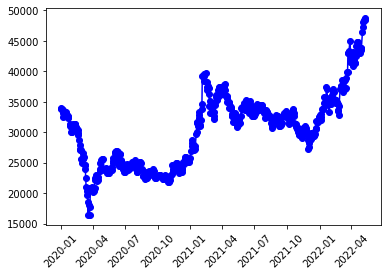

In [85]:
plt.plot(df['Close'], 'bo-')
plt.xticks(rotation=45)

## 1-2. Naver API 키워드 검색 데이터 불러오기

In [86]:
import os
import sys
import urllib.request
client_id = "8sAydq_QSOxKcICuD2Og"
client_secret = "OruQjbmaXF"
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\"2020-01-01\",\"endDate\":\"2022-05-10\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\"KAI_0\",\"keywords\":[\"누리호\"]}, {\"groupName\":\"KAI_1\",\"keywords\":[\"실적\"]}, {\"groupName\":\"KAI_2\",\"keywords\":[\"실패\"]}]}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
    search_count = response_body.decode('utf-8')
else:
    print("Error Code:" + rescode)

In [87]:
search_count_json = json.loads(search_count)

In [88]:
#search_count_json

## 1-3. 데이터 전처리 및 Merge하기

In [89]:
for idx in range(len(search_count_json["results"])):
  
  df_json = pd.DataFrame(search_count_json["results"][idx]["data"])
  column_name = 'Key_Count'+str(idx)
  df_json.columns = ['Date', column_name]
  df_json['Date'] = pd.to_datetime(df_json['Date'])
  df_json.reset_index(drop=True)
  df_json.set_index("Date")
  #Please refer to the section of "Merging asof" in https://pandas.pydata.org/docs/user_guide/merging.html
  df = pd.merge_asof(df, df_json, on="Date", by="Date")

In [90]:
df_all = df

In [91]:
df_all

Date   Open   High    Low  Close   Volume    Change  Key_Count0  \
0   2020-01-02  34100  34150  33800  33800   228661 -0.007342     0.00603   
1   2020-01-03  33850  34100  33750  33950   294440  0.004438     0.00696   
2   2020-01-06  33850  34700  33800  33900   502565 -0.001473     0.00725   
3   2020-01-07  34100  34100  33450  33700   312663 -0.005900     0.00794   
4   2020-01-08  33600  33650  32450  32450   686442 -0.037092     0.00748   
..         ...    ...    ...    ...    ...      ...       ...         ...   
577 2022-05-03  47100  47750  46150  47200  1619153  0.016146     0.04874   
578 2022-05-04  47300  48700  46650  48150  1750174  0.020127     0.04903   
579 2022-05-06  47800  48950  47300  48500  1091440  0.007269     0.04270   
580 2022-05-09  48600  49950  48300  48800  1578796  0.006186     0.04793   
581 2022-05-10  48150  49000  47850  48350  1179680 -0.009221     0.04578   

     Key_Count1  Key_Count2  
0       0.01166     0.01334  
1       0.01212     0.01415  
2       0.01247     0.01549  
3       0.01531     0.01601  
4       0.01613     0.01810  
..          ...         ...  
577     0.01381     0.01926  
578     0.01195     0.01735  
579     0.00899     0.01758  
580     0.01375     0.01967  
581     0.01363     0.01827  

[582 rows x 10 columns]

In [92]:
df_all["Change"].sum() # 전체 주가의 변동폭은 2020년부터 현재까지 증가일까 감소일까? 최종 주가는 빠졌는데 놀랍게도 증가함.. 이는 복리의 함정

0.5401458879663686

In [93]:
df_all[df_all["Date"] > '2022-01-01']["Change"].sum() #조금 더 범위를 좁혀 그러면 2022년 전체 주가 변동폭만 검색해보자, 역시 폭락중 불쌍한 임교수

0.4325107515158091

In [94]:
df_all[df_all["Key_Count0"].notnull()]["Change"].sum() # 그렇다면 해당 키워드가 검색된 날만 뽑아 주가가 상승했는지 하락인지 살펴보자.

0.5401458879663686

In [95]:
# Fill nan as 0
df_all = df_all.fillna(0)
df_all.any().isnull()

Date          False
Open          False
High          False
Low           False
Close         False
Volume        False
Change        False
Key_Count0    False
Key_Count1    False
Key_Count2    False
dtype: bool

In [96]:
df_all

Date   Open   High    Low  Close   Volume    Change  Key_Count0  \
0   2020-01-02  34100  34150  33800  33800   228661 -0.007342     0.00603   
1   2020-01-03  33850  34100  33750  33950   294440  0.004438     0.00696   
2   2020-01-06  33850  34700  33800  33900   502565 -0.001473     0.00725   
3   2020-01-07  34100  34100  33450  33700   312663 -0.005900     0.00794   
4   2020-01-08  33600  33650  32450  32450   686442 -0.037092     0.00748   
..         ...    ...    ...    ...    ...      ...       ...         ...   
577 2022-05-03  47100  47750  46150  47200  1619153  0.016146     0.04874   
578 2022-05-04  47300  48700  46650  48150  1750174  0.020127     0.04903   
579 2022-05-06  47800  48950  47300  48500  1091440  0.007269     0.04270   
580 2022-05-09  48600  49950  48300  48800  1578796  0.006186     0.04793   
581 2022-05-10  48150  49000  47850  48350  1179680 -0.009221     0.04578   

     Key_Count1  Key_Count2  
0       0.01166     0.01334  
1       0.01212     0.01415  
2       0.01247     0.01549  
3       0.01531     0.01601  
4       0.01613     0.01810  
..          ...         ...  
577     0.01381     0.01926  
578     0.01195     0.01735  
579     0.00899     0.01758  
580     0.01375     0.01967  
581     0.01363     0.01827  

[582 rows x 10 columns]

## 1-4. Feature Selection

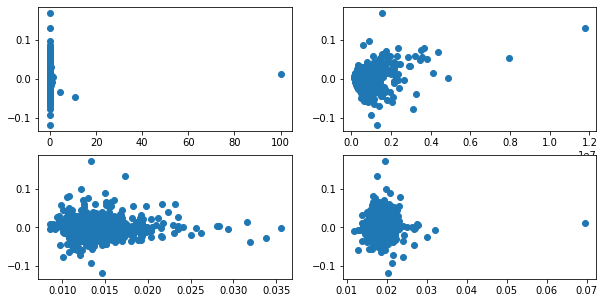

In [97]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(df_all["Key_Count0"], df_all["Change"])
ax2.scatter(df_all["Volume"], df_all["Change"])
ax3.scatter(df_all["Key_Count1"], df_all["Change"])
ax4.scatter(df_all["Key_Count2"], df_all["Change"])


# 2. Define Model

In [98]:
class LinearModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim, bias=True)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_dim, output_dim, bias=True)


    def forward(self, x):
        x = self.linear1(x.unsqueeze(0))
        y = self.relu(x)
        z = self.linear2(y)
        return z

# 3. Define the loss function and the optimizer

In [99]:
input_dim = 3
hidden_dim = 100
output_dim = 1
learning_rate = 0.001
model = LinearModel(input_dim, hidden_dim, output_dim)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

# 4. Define train function

In [100]:
def train(train_x, train_y, loss_function, optimizer, model):
  total_loss = []

  for idx in range(len(train_x)):
    model.train()
    optimizer.zero_grad()
    train_x_tensor = torch.tensor(train_x[idx]).float() #convert numpy to torch tensor
    train_y_tensor = torch.tensor(train_y[idx]).float()
    print(train_x_tensor)
    logit = model(train_x_tensor)
    loss = loss_function(logit, train_y_tensor)
    total_loss.append(loss.item())

    loss.backward()
    optimizer.step()

  return total_loss

# 5. Training 

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['Scaled_Key_Count0', 'Scaled_Key_Count1', 'Scaled_Key_Count2']] = scaler.fit_transform(df[['Key_Count0', 'Key_Count1', 'Key_Count2']])

In [102]:
df_all = df

In [103]:
df_all = df_all.fillna(0)
df_all.any().isnull()

Date                 False
Open                 False
High                 False
Low                  False
Close                False
Volume               False
Change               False
Key_Count0           False
Key_Count1           False
Key_Count2           False
Scaled_Key_Count0    False
Scaled_Key_Count1    False
Scaled_Key_Count2    False
dtype: bool

In [104]:
x_scaled = df_all[['Scaled_Key_Count0', 'Scaled_Key_Count1', 'Scaled_Key_Count2']].to_numpy()
y_scaled = df_all["Change"].to_numpy()

train_x, test_x, train_y, test_y = train_test_split(x_scaled, y_scaled, test_size=0.2)

In [105]:
best_model = None
num_epoch = 100
loss_epoch = []

for epoch in range(num_epoch):
  loss_list = train(train_x, train_y, loss_function, optimizer, model)
  loss_epoch.append(sum(loss_list)/len(train_x))

tensor([0.0003, 0.1552, 0.0956])
tensor([8.4104e-05, 1.3591e-01, 1.5099e-01])
tensor([0.0003, 0.2544, 0.0745])
tensor([0.0000, 0.1229, 0.1007])
tensor([1.4861e-04, 1.8344e-01, 7.4453e-02])
tensor([0.0007, 0.0991, 0.1118])
tensor([4.8202e-05, 7.9837e-02, 7.8619e-02])
tensor([2.5001e-05, 9.9146e-02, 8.8684e-02])
tensor([8.0703e-05, 1.9829e-01, 1.1680e-01])
tensor([2.8401e-05, 1.3814e-01, 1.3589e-01])
tensor([3.1901e-05, 1.8121e-01, 8.0528e-02])
tensor([1.1600e-05, 1.7898e-01, 1.3190e-01])
tensor([1.0270e-04, 4.0290e-01, 1.0274e-01])
tensor([9.3404e-05, 4.1589e-01, 1.0066e-01])
tensor([9.6304e-05, 7.3524e-02, 9.5627e-02])
tensor([9.4004e-05, 1.4222e-01, 8.1569e-02])
tensor([1.3401e-05, 3.4274e-01, 1.3398e-01])
tensor([9.9004e-06, 8.4293e-02, 1.1489e-01])
tensor([0.0002, 0.1077, 0.1269])
tensor([6.2703e-05, 1.6599e-01, 1.1576e-01])
tensor([6.7903e-05, 2.4137e-01, 9.0594e-02])
tensor([0.0002, 0.0928, 0.1401])
tensor([2.9001e-05, 1.4222e-01, 1.4908e-01])
tensor([0.0005, 0.1144, 0.1510])
tens

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
tensor([1.8741e-04, 3.4905e-01, 1.1888e-01])
tensor([0.0005, 0.1251, 0.1258])
tensor([8.3604e-05, 2.4805e-01, 1.3797e-01])
tensor([8.7104e-05, 1.8752e-01, 7.6536e-02])
tensor([3.4801e-05, 1.8344e-01, 1.2392e-01])
tensor([0.0009, 0.1400, 0.0795])
tensor([1.9441e-04, 2.0275e-01, 1.6106e-01])
tensor([0.0002, 0.1400, 0.1027])
tensor([0.0002, 0.1920, 0.1017])
tensor([0.0007, 0.0843, 0.0906])
tensor([6.2703e-05, 2.1129e-01, 1.5915e-01])
tensor([1.2421e-04, 2.1129e-01, 1.2079e-01])
tensor([0.0002, 0.1337, 0.1099])
tensor([5.5102e-05, 3.9658e-01, 8.0528e-02])
tensor([1.3401e-05, 2.1983e-01, 1.7824e-01])
tensor([0.0004, 0.0951, 0.1430])
tensor([0.0005, 0.1853, 0.0837])
tensor([0.0002, 0.1229, 0.1409])
tensor([1.8601e-05, 2.3914e-01, 1.0569e-01])
tensor([0.0015, 0.1530, 0.1118])
tensor([0.0008, 0.1682, 0.0805])
tensor([3.7102e-05, 1.8344e-01, 9.3717e-02])
tensor([4.6402e-05, 3.2974e-01, 1.2287e-01])
tensor([4.7002e-06, 1.1846e-01, 6.2478e-02])
tensor([0.0005, 

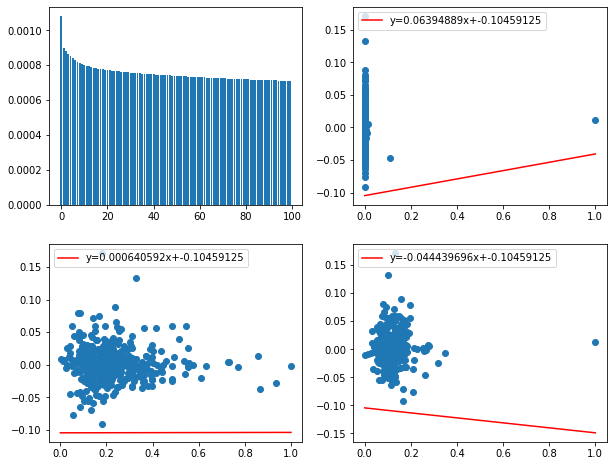

In [106]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.bar(range(100), loss_epoch)
ax2.scatter(train_x.transpose()[0], train_y)
x = np.linspace(0,1,100)
linear_weight = model.linear2.weight.detach().numpy()
lienar_bias = model.linear2.bias.detach().numpy()
y = linear_weight.transpose()[0]*x+lienar_bias
y = y.reshape((100))
ax2.plot(x, y, '-r', label='y='+str(linear_weight[0][0])+'x+'+str(lienar_bias[-1]))
ax2.legend(loc='upper left')

ax3.scatter(train_x.transpose()[1], train_y)
x = np.linspace(0,1,100)
linear_weight = model.linear2.weight.detach().numpy()
lienar_bias = model.linear2.bias.detach().numpy()
y = linear_weight.transpose()[1]*x+lienar_bias
y = y.reshape((100))
ax3.plot(x, y, '-r', label='y='+str(linear_weight[0][1])+'x+'+str(lienar_bias[-1]))
ax3.legend(loc='upper left')

ax4.scatter(train_x.transpose()[2], train_y)
x = np.linspace(0,1,100)
linear_weight = model.linear2.weight.detach().numpy()
lienar_bias = model.linear2.bias.detach().numpy()
y = linear_weight.transpose()[2]*x+lienar_bias
y = y.reshape((100))
ax4.plot(x, y, '-r', label='y='+str(linear_weight[0][2])+'x+'+str(lienar_bias[-1]))
ax4.legend(loc='upper left')

In [107]:
x_predicted = []
for idx in range(len(train_x)):
    train_x_tensor = torch.tensor(train_x[idx]).float()
    x_predict = model(train_x_tensor)
    x_predicted.append(x_predict.detach())

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


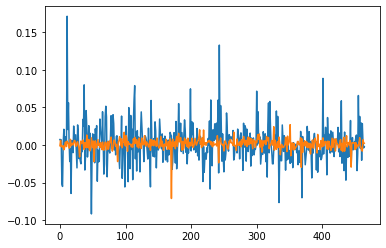

In [108]:
plt.plot(train_y)
plt.plot(x_predicted)

# 6. Prediction

In [109]:
def predict(key_count, model):
  model.eval()
  logit = model(key_count)
  return logit

In [110]:
key_count = np.array([[20, 30, 1]])
scaled_input = scaler.transform(key_count.reshape(1,-1))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [111]:
df_all.max()
predicted = predict(torch.FloatTensor(scaled_input), model)

In [112]:
print("검색량이"+str(key_count)+"일때 주가는", str(predicted.item()*100) )

검색량이[[20 30  1]]일때 주가는 -10157.233428955078


In [113]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train